In [1]:
import torch
import torch.nn as nn
import crypten
import random

# Load Model and Encryption

## load comb net

In [2]:
from crypten_utils import LeNet, get_input_size, construct_private_model, validate_comb
from utils import load_cifar10

In [3]:
trainloader, testloader = load_cifar10(data_dir="../data/cifar10", batch_size=128, 
                                       test_batch = 128,train_shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
seed = 100
random.seed(seed)
torch.manual_seed(seed)

crypten.init()

In [5]:
criterion = nn.NLLLoss()

## load fake and orig models

In [6]:
net_real = LeNet()
net_fake = LeNet()

In [7]:
aa = torch.tensor([1.0,0.7])>0.5
aa

tensor([True, True])

In [8]:
net_real.load_state_dict(torch.load("../results/cifar_logit_lenet.pth",map_location='cpu'))
net_fake.load_state_dict(torch.load("../results/cifar_fake_lenet_swd.pth",map_location='cpu'))

<All keys matched successfully>

In [9]:
from crypten_utils import inference_combmodel

In [10]:
data = list(iter(testloader))[0]

In [11]:
x,y = data[0],data[1]

In [12]:
pred = inference_combmodel(net_real, net_fake, x, tau=0.5, cond_bool=True)

/home/saerom/.pyenv/versions/crypten/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


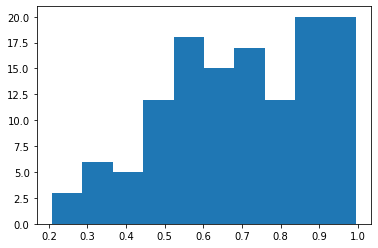

In [18]:
import matplotlib.pyplot as plt

plt.hist(pred.max(dim=1)[0].detach().numpy())
plt.show()

In [19]:
criterion = nn.NLLLoss()

In [22]:
loss = criterion(pred.log(), y)

In [23]:
loss

tensor(2.5542, grad_fn=<NllLossBackward>)

In [8]:
input_size = get_input_size(testloader, batch_size=128)

In [9]:
netr_enc = construct_private_model(input_size, net_real)
netf_enc = construct_private_model(input_size, net_fake)

/home/saerom/.pyenv/versions/crypten/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/saerom/.pyenv/versions/crypten/lib/python3.8/site-packages/crypten/nn/onnx_converter.py:161: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  param = torch

In [10]:
validate_comb(testloader, netr_enc, netf_enc, criterion, tau = 0.5)

world size 1


/home/saerom/.pyenv/versions/crypten/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


tensor(46.4800)

In [10]:
validate(testloader, netr_enc, criterion)

/home/saerom/.pyenv/versions/crypten/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


tensor(60.6900)

In [11]:
def validate_comb(val_loader, model1, model2, tau = 0.5, print_freq=10):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top3 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            if isinstance(model1, crypten.nn.Module) and isinstance(model2, crypten.nn.Module) and not crypten.is_encrypted_tensor(
                input
            ):
                input = encrypt_data_tensor_with_src(input)
                
            # compute output
            output = inference_combmodel(model1, model2, input, tau)
            if crypten.is_encrypted_tensor(output):
                output = output.get_plain_text()
            loss = criterion(output, target)

            # measure accuracy and record loss
            prec1, prec3 = accuracy(output, target, topk=(1, 3))
            losses.add(loss.item(), input.size(0))
            top1.add(prec1[0], input.size(0))
            top3.add(prec3[0], input.size(0))

            # measure elapsed time
            current_batch_time = time.time() - end
            batch_time.add(current_batch_time)
            end = time.time()

            if (i + 1) % print_freq == 0:
                logging.info(
                    "\nTest: [{}/{}]\t"
                    "Time {:.3f} ({:.3f})\t"
                    "Loss {:.4f} ({:.4f})\t"
                    "Prec@1 {:.3f} ({:.3f})   \t"
                    "Prec@5 {:.3f} ({:.3f})".format(
                        i + 1,
                        len(val_loader),
                        current_batch_time,
                        batch_time.value(),
                        loss.item(),
                        losses.value(),
                        prec1[0],
                        top1.value(),
                        prec3[0],
                        top3.value(),
                    )
                )

        logging.info(
            " * Prec@1 {:.3f} Prec@3 {:.3f}".format(top1.value(), top3.value())
        )
    return top1.value()

In [12]:
def inference_combmodel(net1_enc, net2_enc, x, tau=0.5):
    print("first inference")
    x1 = net1_enc(x).softmax(dim=1)
    x2 = net2_enc(x).softmax(dim=1)
    max_val = x1.max(dim=1)[0]
    cond_in = max_val>tau
    out = x1*cond_in.view(-1,1) + x2*(1-cond_in.view(-1,1))
    return out

## histograms for combNet

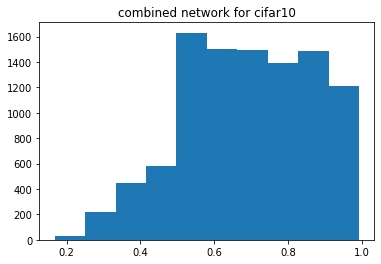

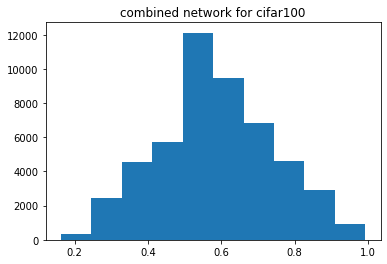

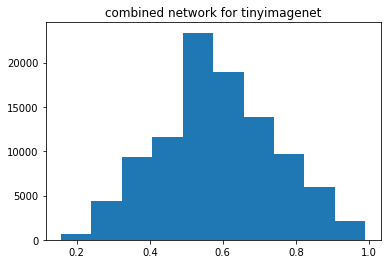

In [11]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, comb_net, device, plt_title="combined network for cifar10")
maxclass_hist(stealloader, comb_net, device, plt_title="combined network for cifar100")
maxclass_hist(outlier_loader, comb_net, device, plt_title="combined network for tinyimagenet")

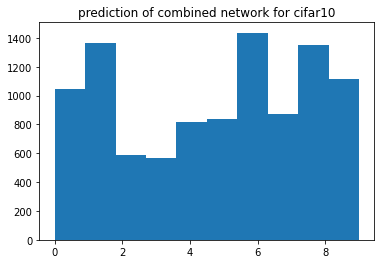

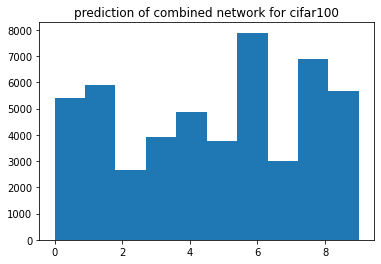

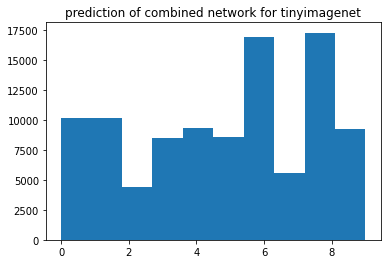

In [12]:
prediction_hist(testloader, comb_net, device, plt_title="prediction of combined network for cifar10")
prediction_hist(stealloader, comb_net, device, plt_title="prediction of combined network for cifar100")
prediction_hist(outlier_loader, comb_net, device, plt_title="prediction of combined network for tinyimagenet")

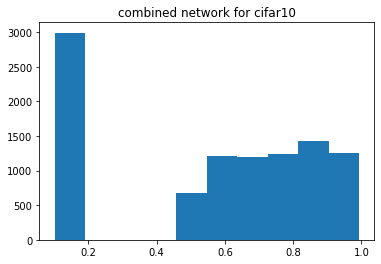

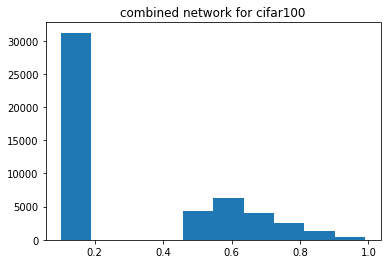

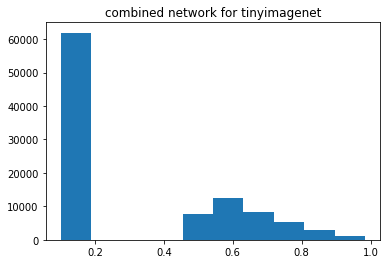

In [11]:
from utils import maxclass_hist, prediction_hist
maxclass_hist(testloader, comb_net, device, plt_title="combined network for cifar10")
maxclass_hist(stealloader, comb_net, device, plt_title="combined network for cifar100")
maxclass_hist(outlier_loader, comb_net, device, plt_title="combined network for tinyimagenet")

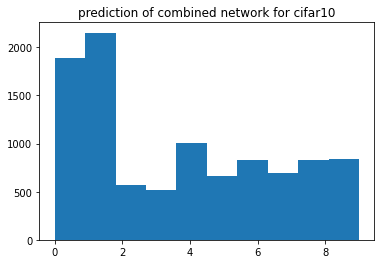

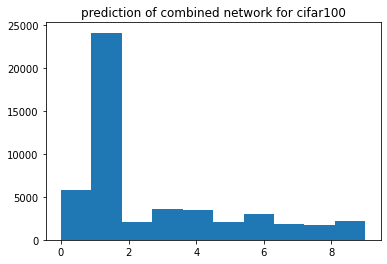

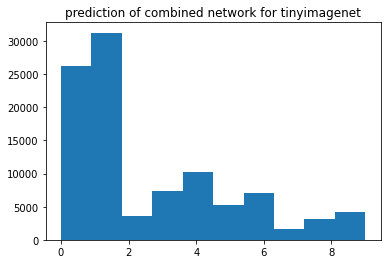

In [12]:
prediction_hist(testloader, comb_net, device, plt_title="prediction of combined network for cifar10")
prediction_hist(stealloader, comb_net, device, plt_title="prediction of combined network for cifar100")
prediction_hist(outlier_loader, comb_net, device, plt_title="prediction of combined network for tinyimagenet")

## train attack network with hard label

In [14]:
from utils import train_stmodel_comb_hard_label, select_data,test_corr_model

In [15]:
att_net = AttackNet()

In [16]:
criterion_att = nn.CrossEntropyLoss()
optimizer_att = optim.SGD(att_net.parameters(), lr=0.001, momentum=0.9)

In [17]:
selected_loader = select_data(stealloader.dataset, args.nb_stolen,
                              trainloader.batch_size, False)

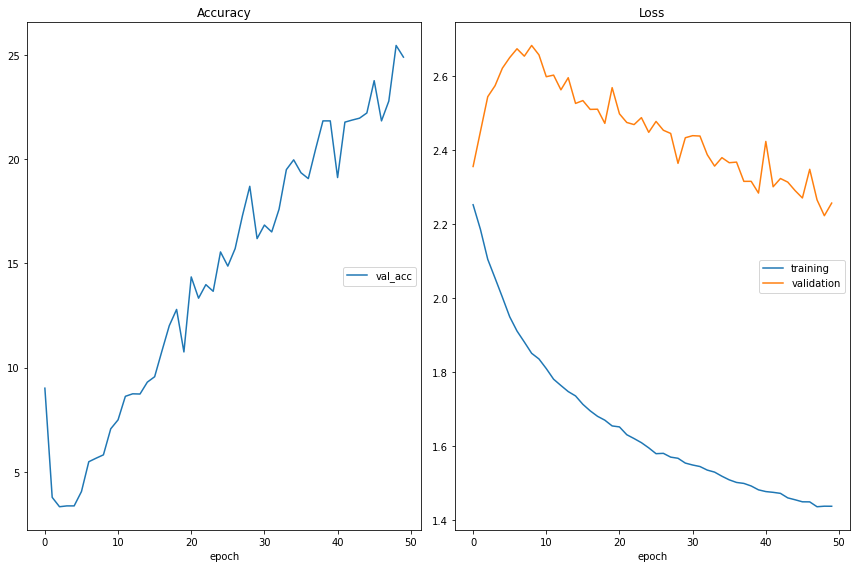

Accuracy
	val_acc          	 (min:    3.320, max:   25.460, cur:   24.900)
Loss
	training         	 (min:    1.435, max:    2.252, cur:    1.437)
	validation       	 (min:    2.222, max:    2.682, cur:    2.256)


In [18]:
att_net, logs_att = train_stmodel_comb_hard_label(selected_loader, att_net, criterion_att, optimizer_att, comb_net, 
                                       epochs=args.att_epochs, device=device, test_loader=testloader, 
                                         save_dir = args.save_dir, 
                                       save_model=args.att_model)

## train attack network for multiple taus

- 그냥 여러 tau 에 대해서 다 돌려놓아 보고 싶을 때 이 부분 활용!

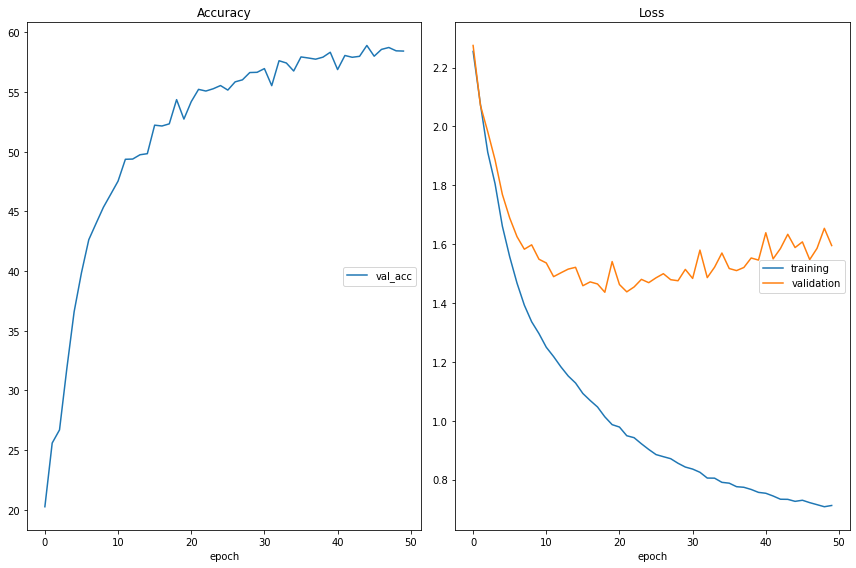

Accuracy
	val_acc          	 (min:   20.250, max:   58.910, cur:   58.440)
Loss
	training         	 (min:    0.708, max:    2.255, cur:    0.712)
	validation       	 (min:    1.437, max:    2.275, cur:    1.595)


NameError: name 'test_corr_model' is not defined

In [13]:
from utils import train_stmodel_comb, select_data,test_corr_model
import numpy as np
print(args)
selected_loader = select_data(stealloader.dataset, args.nb_stolen, trainloader.batch_size, False)

for tau in np.arange(0.1, 1.1, 0.1): 
    comb_net = CombNet(net, net_fake, tau=tau)
    att_net = AttackNet()
    criterion_att = nn.CrossEntropyLoss()
    optimizer_att = optim.SGD(att_net.parameters(), lr=0.001, momentum=0.9)
    print("train for tau",tau)
    _, logs_att = train_stmodel_comb(selected_loader, att_net, criterion_att, optimizer_att, comb_net, 
                                       epochs=args.att_epochs, device=device, test_loader=testloader, 
                                         save_dir = args.save_dir, 
                                       save_model=str(tau)+"_cifar_att_net.pth")
    loss1, loss2, acc1, acc2, corr = test_corr_model(comb_net, att_net, testloader, criterion_att, device)
    del loss1, loss2, acc1, acc2, corr, comb_net, att_net
    torch.cuda.empty_cache()

### load att net

In [15]:
att_net = AttackNet()
att_net.load_state_dict(torch.load(os.path.join(args.save_dir,args.att_model),map_location='cpu'))

<All keys matched successfully>

## test steal model

In [19]:
from utils import test_corr_model
criterion_att = nn.CrossEntropyLoss()
loss1, loss2, acc1, acc2, corr = test_corr_model(comb_net, att_net, testloader, criterion_att, device)

Accuracy/Loss 1: 62.96/1.9312
Accuracy/Loss 2: 24.90/2.2561
Correspondence:  tensor(42.4800)
